# Parse Schema

In [1]:
import sqlglot
from sqlglot import expressions as exp

def parse_schema(sql_file):
    with open(sql_file, 'r') as f:
        schema_ddl = f.read()

        # Parse the schema
        schema = {}
        for statement in sqlglot.parse(schema_ddl, dialect='mysql'):
            if isinstance(statement, exp.Create):
                table_name = statement.find(exp.Table).name
                schema[table_name] = {
                    'columns': [],
                    'primary_keys': [],
                    'foreign_keys': []
                }
                # Extract columns
                for column_def in statement.find_all(exp.ColumnDef):
                    column_info = {
                        'name': column_def.name,
                        'type': column_def.args['kind'].sql(dialect='mysql'),
                        'constraints': []
                    }

                    # Check for constraints
                    if column_def.args.get('constraints'):
                        for constraint in column_def.args['constraints']:
                            column_info['constraints'].append(str(constraint))
                    schema[table_name]['columns'].append(column_info)

                #Extract primary keys
                for primary_keys in statement.find_all(exp.PrimaryKey):
                    for primary_key in primary_keys:
                        schema[table_name]['primary_keys'].append(primary_key.name)

        
                #Extract foreign keys
                for constraint in statement.find_all(exp.Constraint):
                    constraint_info = {
                        'name': constraint.name,
                        'foreign_key': '',
                        'reference_table': '',
                        'reference_column': ''
                    }
                    for foreign_keys in constraint.find_all(exp.ForeignKey):
                        constraint_info['foreign_key'] = foreign_keys.expressions[0].name
                            
                            
                    for references in constraint.find_all(exp.Reference):
                        constraint_info['reference_table'] = str(references.args['this']).split()[0].replace('"', '')
                        constraint_info['reference_column'] = str(references.args['this']).split()[1].replace('"', '').replace('(', '').replace(')', '')
                            
                    schema[table_name]['foreign_keys'].append(constraint_info)       
                
    return schema

In [2]:
sql_file = "Dump20250409.sql"
parsed_schema = parse_schema(sql_file)
parsed_schema

{'attribute': {'columns': [{'name': 'id',
    'type': 'BIGINT',
    'constraints': ['NOT NULL', 'AUTO_INCREMENT']},
   {'name': 'object_id', 'type': 'BIGINT', 'constraints': ['NOT NULL']},
   {'name': 'artist', 'type': 'VARCHAR(100)', 'constraints': ['DEFAULT NULL']},
   {'name': 'art_style',
    'type': 'VARCHAR(100)',
    'constraints': ['DEFAULT NULL']},
   {'name': 'material',
    'type': 'VARCHAR(100)',
    'constraints': ['DEFAULT NULL']},
   {'name': 'created_at',
    'type': 'DATETIME',
    'constraints': ['NOT NULL', 'DEFAULT CURRENT_TIMESTAMP()']},
   {'name': 'updated_at',
    'type': 'DATETIME',
    'constraints': ['DEFAULT NULL', 'ON UPDATE CURRENT_TIMESTAMP()']}],
  'primary_keys': ['id'],
  'foreign_keys': [{'name': 'fk_museum_object_attribute',
    'foreign_key': 'object_id',
    'reference_table': 'museum_object',
    'reference_column': 'id'}]},
 'entrance': {'columns': [{'name': 'id',
    'type': 'BIGINT',
    'constraints': ['NOT NULL', 'AUTO_INCREMENT']},
   {'name

# Build Knowledge Graph

In [3]:
import networkx as nx
from collections import defaultdict

def build_knowledge_graph(schema_dict):
    """Convert parsed SQL schema into a knowledge graph"""
    kg = nx.MultiDiGraph()
    
    # First pass: create all table and column nodes
    for table_name, table_info in schema_dict.items():
        # Add table node
        kg.add_node(f"table_{table_name}", 
                   type="table",
                   name=table_name,
                   num_columns=len(table_info['columns']))
        
        # Add column nodes
        for col in table_info['columns']:
            col_id = f"column_{table_name}.{col['name']}"
            kg.add_node(col_id,
                       type="column",
                       name=col['name'],
                       data_type=col['type'],
                       nullable=all("NOT NULL" not in c for c in col['constraints']),
                       is_auto_increment="AUTO_INCREMENT" in col['constraints'],
                       has_default=any("DEFAULT" in c for c in col['constraints']))
            
            # Add BELONGS_TO edge
            kg.add_edge(col_id, f"table_{table_name}", relation="BELONGS_TO")
    
    # Second pass: add constraints and relationships
    for table_name, table_info in schema_dict.items():
        # Add primary key relationships
        for pk in table_info['primary_keys']:
            col_id = f"column_{table_name}.{pk}"
            kg.add_edge(col_id, f"table_{table_name}", relation="PRIMARY_KEY_OF")
        
        # Add foreign key relationships
        for fk in table_info['foreign_keys']:
            if not fk['foreign_key']:  # Skip empty constraints
                continue
                
            src_col = f"column_{table_name}.{fk['foreign_key']}"
            tgt_table = f"table_{fk['reference_table']}"
            tgt_col = f"column_{fk['reference_table']}.{fk['reference_column']}"
            
            # Add FOREIGN_KEY_TO edge between columns
            kg.add_edge(src_col, tgt_col, relation="FOREIGN_KEY_TO")
            
            # Add REFERENCES edge between tables
            kg.add_edge(f"table_{table_name}", tgt_table, relation="REFERENCES")
    
    return kg

In [4]:
knowledge_graph = build_knowledge_graph(parsed_schema)

# Visualize Knowledge Graph

## Matplotlib

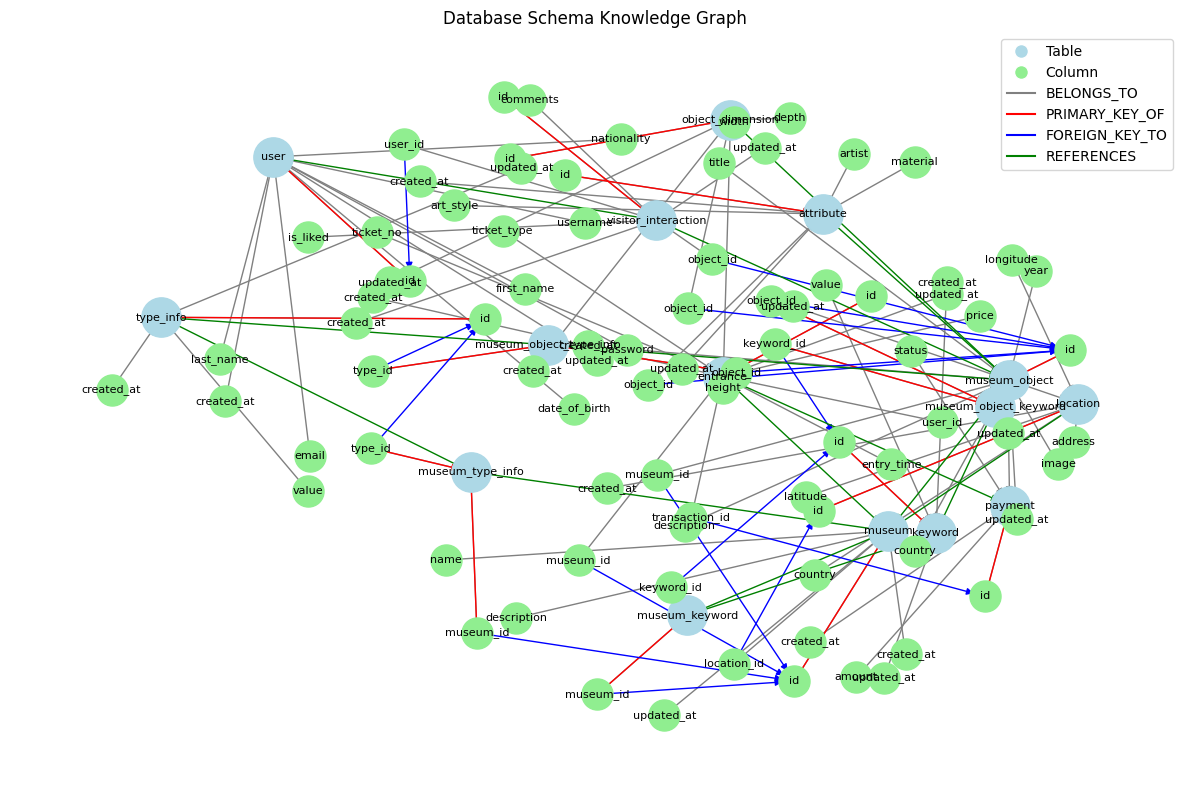

In [5]:
import matplotlib.pyplot as plt

def visualize_kg_basic(kg):
    plt.figure(figsize=(12, 8))
    
    # Position nodes using spring layout
    pos = nx.spring_layout(kg, k=0.5, iterations=50)
    
    # Draw nodes by type
    table_nodes = [n for n in kg.nodes() if kg.nodes[n]['type'] == 'table']
    column_nodes = [n for n in kg.nodes() if kg.nodes[n]['type'] == 'column']
    
    nx.draw_networkx_nodes(kg, pos, nodelist=table_nodes, node_color='lightblue', node_size=800)
    nx.draw_networkx_nodes(kg, pos, nodelist=column_nodes, node_color='lightgreen', node_size=500)
    
    # Draw edges by relation type
    edge_colors = {
        'BELONGS_TO': 'gray',
        'PRIMARY_KEY_OF': 'red',
        'FOREIGN_KEY_TO': 'blue',
        'REFERENCES': 'green'
    }
    
    for relation, color in edge_colors.items():
        edges = [(u, v) for u, v, d in kg.edges(data=True) if d['relation'] == relation]
        nx.draw_networkx_edges(kg, pos, edgelist=edges, edge_color=color, arrows=True)
    
    # Draw labels
    node_labels = {n: kg.nodes[n]['name'] for n in kg.nodes()}
    nx.draw_networkx_labels(kg, pos, labels=node_labels, font_size=8)
    
    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', label='Table', markerfacecolor='lightblue', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Column', markerfacecolor='lightgreen', markersize=10),
        plt.Line2D([0], [0], color='gray', label='BELONGS_TO'),
        plt.Line2D([0], [0], color='red', label='PRIMARY_KEY_OF'),
        plt.Line2D([0], [0], color='blue', label='FOREIGN_KEY_TO'),
        plt.Line2D([0], [0], color='green', label='REFERENCES')
    ]
    
    plt.legend(handles=legend_elements, loc='upper right')
    plt.title("Database Schema Knowledge Graph")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Usage
visualize_kg_basic(knowledge_graph)

## PyVis

In [6]:
from pyvis.network import Network

def visualize_kg_interactive(kg, filename='kg.html'):
    net = Network(notebook=True, directed=True, height="750px", width="100%")
    
    # Add nodes
    for node in kg.nodes():
        node_data = kg.nodes[node]
        color = '#9ECAE1' if node_data['type'] == 'table' else '#A1D99B'
        title = f"Type: {node_data['type']}\nName: {node_data['name']}"
        
        if node_data['type'] == 'column':
            title += f"\nData Type: {node_data['data_type']}\nNullable: {node_data['nullable']}"
        
        net.add_node(node, label=node_data['name'], color=color, title=title)
    
    # Add edges
    for src, tgt, data in kg.edges(data=True):
        edge_attrs = {
            'BELONGS_TO': {'color': 'gray', 'dashes': False},
            'PRIMARY_KEY_OF': {'color': 'red', 'dashes': False},
            'FOREIGN_KEY_TO': {'color': 'blue', 'dashes': False},
            'REFERENCES': {'color': 'green', 'dashes': True}
        }
        net.add_edge(src, tgt, title=data['relation'], **edge_attrs[data['relation']])
    
    # Configure physics
    net.set_options("""
    {
      "physics": {
        "hierarchicalRepulsion": {
          "centralGravity": 0,
          "springLength": 200,
          "springConstant": 0.01,
          "nodeDistance": 200,
          "damping": 0.09
        },
        "minVelocity": 0.75,
        "solver": "hierarchicalRepulsion"
      }
    }
    """)
    
    net.show(filename)

# Usage
visualize_kg_interactive(knowledge_graph)

kg.html


# Parse Queries

In [7]:
from dataclasses import dataclass, field
from typing import Dict, List, Set, Tuple, Optional
import sqlglot
from sqlglot import expressions as exp

@dataclass
class QueryComponents:
    raw_query: str
    query_type: str
    tables: Set[str] = field(default_factory=set)
    columns: Set[str] = field(default_factory=set)
    joins: List[Dict] = field(default_factory=list)
    conditions: List[Dict] = field(default_factory=list)
    aggregations: Set[str] = field(default_factory=set)
    subqueries: Set[str] = field(default_factory=set)
    group_by: List[str] = field(default_factory=list)
    order_by: List[Dict] = field(default_factory=list)
    limit: Optional[int] = None
    having: List[str] = field(default_factory=list)
    ctes: Dict[str, dict] = field(default_factory=dict)

In [8]:
def _extract_ctes(parsed: exp.Expression, components: QueryComponents):
    """Extract Common Table Expressions (CTEs)."""
    if isinstance(parsed, exp.With):
        for cte in parsed.expressions:
            cte_name = cte.alias
            cte_query = cte.this.sql()
            components.ctes[cte_name] = {
                "query": cte_query,
                "tables": set(),
                "columns": set()
            }
            # Recursively parse CTE
            cte_components = parse_sql(cte_query)
            components.ctes[cte_name].update({
                "tables": cte_components.tables,
                "columns": cte_components.columns
            })
            components.tables.add(cte_name)

In [9]:
def _extract_table_aliases(parsed: exp.Expression) -> Dict[str, str]:
    """Extract table names and their aliases."""
    table_aliases = {}
    for table in parsed.find_all(exp.Table):
        table_name = table.name
        table_aliases[table_name] = table_name
        if table.alias:
            table_aliases[table.alias] = table_name
    return table_aliases

In [10]:
def _extract_columns(parsed: exp.Expression, 
                    components: QueryComponents, 
                    table_aliases: Dict[str, str]):
    """Extract columns with proper table context."""
    for col in parsed.find_all(exp.Column):
        table_name = table_aliases.get(col.table, col.table)
        components.columns.add(f"{table_name}.{col.name}")

In [11]:
def _extract_joins(parsed: exp.Expression, 
                  components: QueryComponents,
                  table_aliases: Dict[str, str]):
    """Extract join relationships between tables with conditions."""
    # Handle both explicit JOINs and comma-separated joins
    for join in parsed.find_all(exp.Join):
        source_table = join.args.get('on').find(sqlglot.exp.Column).table
        if source_table:
            source_table = table_aliases.get(source_table, source_table)
        
        target_table = join.this.alias or join.this.name
        if target_table:
            target_table = table_aliases.get(target_table, target_table)
        
        join_conditions = []
        if join.args.get("on"):
            left = join.args.get("on").left.name
            right = join.args.get("on").right.name
            join_conditions.append({"left": left, "right": right, "operator": "="})
        
        if source_table and target_table:
            components.joins.append({
                "source": source_table,
                "target": target_table,
                "type": join.side + " JOIN" if join.side else "JOIN",
                "conditions": join_conditions
            })

In [12]:
def _extract_conditions(parsed: exp.Expression, components: QueryComponents):
    """Extract WHERE clause conditions with proper nesting."""
    for where in parsed.find_all(exp.Where):
        # Handle both simple and complex conditions
        for condition in where.flatten():
            if isinstance(condition, (exp.Connector, exp.Condition)):
                if isinstance(condition, exp.Connector):
                    # Handle AND/OR conditions
                    left = condition.left.sql()
                    right = condition.right.sql()
                    components.conditions.append({
                        "left": left,
                        "operator": condition.key,
                        "right": right,
                        "connector": condition.key
                    })
                else:
                    # Handle comparison conditions
                    components.conditions.append({
                        "left": condition.left.sql(),
                        "operator": condition.key,
                        "right": condition.right.sql()
                    })

In [13]:
def _extract_aggregations(parsed: exp.Expression, components: QueryComponents):
    """Extract aggregation functions and their columns."""
    for agg in parsed.find_all(exp.AggFunc):
        components.aggregations.add(agg.sql())
        # Also add the column being aggregated
#         if isinstance(agg.this, exp.Column):
#             components.columns.add(agg.this.sql())

In [14]:
def _extract_subqueries(parsed: exp.Expression, components: QueryComponents):
    """Identify and extract subqueries."""
    for subquery in parsed.find_all(exp.Subquery):
        components.subqueries.add(subquery.sql())

In [15]:
def _extract_group_by(parsed: exp.Expression, components: QueryComponents):
    """Extract GROUP BY columns."""
    for group in parsed.find_all(exp.Group):
        for column in group.expressions:
            if isinstance(column, exp.Column):
                components.group_by.append(column.sql())

In [16]:
def _extract_order_by(parsed: exp.Expression, components: QueryComponents):
    """Extract ORDER BY clauses with direction."""
    for order in parsed.find_all(exp.Order):
        for expr in order.expressions:
            if isinstance(expr, exp.Ordered):
                direction = expr.args.get("desc") and "DESC" or "ASC"
                column = expr.this.sql()
                components.order_by.append({
                    "column": column,
                    "direction": direction
                })

In [17]:
def _extract_having(parsed: exp.Expression, components: QueryComponents):
    """Extract HAVING clause conditions."""
    for having in parsed.find_all(exp.Having):
        components.having.append(having.this.sql())

In [18]:
def _extract_limit(parsed: exp.Expression) -> Optional[int]:
    """Extract LIMIT value if present."""
    limit = parsed.find(exp.Limit)
    if limit and limit.args.get("expression"):
        return int(limit.args["expression"].sql())
    return None

In [19]:
def parse_sql(query: str) -> QueryComponents:
    """Parse SQL query into structured components with complete extraction."""
    try:
        parsed = sqlglot.parse_one(query)
        if not parsed:
            raise ValueError("Failed to parse query")
        
        components = QueryComponents(
            raw_query=query,
            query_type=parsed.key.upper()
        )
        
        # Extract CTEs first
        _extract_ctes(parsed, components)
        
        # Extract tables and their aliases from main query
        table_aliases = _extract_table_aliases(parsed)
        components.tables.update(table_aliases.values())
        
        # Extract all query components
        _extract_columns(parsed, components, table_aliases)
        _extract_joins(parsed, components, table_aliases)
        _extract_conditions(parsed, components)
        _extract_aggregations(parsed, components)
        _extract_subqueries(parsed, components)
        _extract_group_by(parsed, components)
        _extract_order_by(parsed, components)
        _extract_having(parsed, components)
        components.limit = _extract_limit(parsed)
        
        return components
        
    except Exception as e:
        raise ValueError(f"Error parsing query: {query}\nError: {str(e)}")

In [20]:
sql_query = """WITH recent_interactions AS (
    SELECT 
        vi.object_id,
        COUNT(vi.id) AS total_interactions
    FROM visitor_interaction vi
    WHERE vi.created_at >= (NOW() - INTERVAL 30 DAY)  
      AND (vi.is_liked = 1 OR vi.comments IS NOT NULL)
    GROUP BY vi.object_id
)
SELECT 
    mo.id AS object_id,
    mo.title AS object_title,
    m.name AS museum_name,
    ri.total_interactions
FROM recent_interactions ri
JOIN museum_object mo ON ri.object_id = mo.id
JOIN museum m ON mo.museum_id = m.id
ORDER BY ri.total_interactions DESC
LIMIT 10;
"""
parsed_query = parse_sql(sql_query)

In [21]:
parsed_query

QueryComponents(raw_query='WITH recent_interactions AS (\n    SELECT \n        vi.object_id,\n        COUNT(vi.id) AS total_interactions\n    FROM visitor_interaction vi\n    WHERE vi.created_at >= (NOW() - INTERVAL 30 DAY)  \n      AND (vi.is_liked = 1 OR vi.comments IS NOT NULL)\n    GROUP BY vi.object_id\n)\nSELECT \n    mo.id AS object_id,\n    mo.title AS object_title,\n    m.name AS museum_name,\n    ri.total_interactions\nFROM recent_interactions ri\nJOIN museum_object mo ON ri.object_id = mo.id\nJOIN museum m ON mo.museum_id = m.id\nORDER BY ri.total_interactions DESC\nLIMIT 10;\n', query_type='SELECT', tables={'recent_interactions', 'museum_object', 'museum', 'visitor_interaction'}, columns={'recent_interactions.object_id', 'recent_interactions.total_interactions', 'museum_object.title', 'museum.name', 'visitor_interaction.object_id', 'visitor_interaction.is_liked', 'visitor_interaction.created_at', 'museum_object.id', 'visitor_interaction.comments', 'visitor_interaction.id', 

In [22]:
parsed_query.query_type

'SELECT'

In [23]:
parsed_query.tables

{'museum', 'museum_object', 'recent_interactions', 'visitor_interaction'}

In [24]:
parsed_query.columns

{'museum.id',
 'museum.name',
 'museum_object.id',
 'museum_object.museum_id',
 'museum_object.title',
 'recent_interactions.object_id',
 'recent_interactions.total_interactions',
 'visitor_interaction.comments',
 'visitor_interaction.created_at',
 'visitor_interaction.id',
 'visitor_interaction.is_liked',
 'visitor_interaction.object_id'}

In [25]:
parsed_query.joins

[{'source': 'recent_interactions',
  'target': 'museum_object',
  'type': 'JOIN',
  'conditions': [{'left': 'object_id', 'right': 'id', 'operator': '='}]},
 {'source': 'museum_object',
  'target': 'museum',
  'type': 'JOIN',
  'conditions': [{'left': 'museum_id', 'right': 'id', 'operator': '='}]}]

In [26]:
parsed_query.conditions

[{'left': "vi.created_at >= (NOW() - INTERVAL '30' DAY)",
  'operator': 'and',
  'right': '(vi.is_liked = 1 OR NOT vi.comments IS NULL)',
  'connector': 'and'}]

In [27]:
parsed_query.aggregations

{'COUNT(vi.id)'}

In [28]:
parsed_query.subqueries

set()

In [29]:
parsed_query.group_by

['vi.object_id']

In [30]:
parsed_query.order_by

[{'column': 'ri.total_interactions', 'direction': 'DESC'}]

In [31]:
parsed_query.limit

10

In [32]:
parsed_query.having

[]

In [33]:
def update_kg_with_query(kg: nx.MultiDiGraph, query_components: QueryComponents) -> nx.MultiDiGraph:
    """
    Update knowledge graph with detailed query components including CTEs, joins, and conditions.
    
    Args:
        kg: Existing knowledge graph
        query_components: Parsed query components
        
    Returns:
        Updated knowledge graph with query relationships
    """
    # Create a unique query node ID
    query_id = f"query_{hash(query_components.raw_query)}"
    print(query_id)
    
    # Add query node with metadata
    kg.add_node(query_id,
               type="query",
               query_type=query_components.query_type,
               has_cte=bool(query_components.ctes),
               has_aggregations=bool(query_components.aggregations),
               has_subqueries=bool(query_components.subqueries),
               limit=query_components.limit)
    
    # Process CTEs (Common Table Expressions)
    _process_ctes(kg, query_id, query_components)
    
    # Process main query components
    _process_main_query(kg, query_id, query_components)
    
    return kg

def _process_ctes(kg: nx.DiGraph, query_id: str, components: QueryComponents):
    """Process CTEs and their relationships."""
    for cte_name, cte_info in components.ctes.items():
        cte_node = f"cte_{cte_name}_{query_id}"
        kg.add_node(cte_node, 
                   type="cte",
                   name=cte_name,
                   definition=cte_info["query"])
        
        # Connect query to CTE
        kg.add_edge(query_id, cte_node, relation="DEFINES")
        
        # Connect CTE to its source tables
        for table in cte_info["tables"]:
            table_node = f"table_{table}"
            if table_node in kg:
                kg.add_edge(cte_node, table_node, relation="DERIVES_FROM")

def _process_main_query(kg: nx.DiGraph, query_id: str, components: QueryComponents):
    """Process the main query components."""
    # Connect to tables
    for table in components.tables:
        table_node = f"table_{table}"
        if table_node in kg:
            kg.add_edge(query_id, table_node, relation="ACCESSES")
            kg.nodes[table_node]["access_count"] = kg.nodes[table_node].get("access_count", 0) + 1
    
    # Process columns and their usage contexts
    _process_columns(kg, query_id, components)
    
    # Process join relationships
    _process_joins(kg, query_id, components)
    
#     # Process conditions (WHERE clauses)
#     _process_conditions(kg, query_id, components)
    _process_condition_part(kg, query_id, components)
    
    # Process ordering (ORDER BY)
    _process_ordering(kg, query_id, components)
    
    # Process aggregations
    _process_aggregations(kg, query_id, components)

def _process_columns(kg: nx.DiGraph, query_id: str, components: QueryComponents):
    """Process column references and their contexts."""
    for column_ref in components.columns:
        if '.' in column_ref:
            table, col = column_ref.split('.')
            col_node = f"column_{table}.{col}"
            
            if col_node in kg:
                # Add basic reference
                kg.add_edge(query_id, col_node, relation="REFERENCES")
                kg.nodes[col_node]["reference_count"] = kg.nodes[col_node].get("reference_count", 0) + 1
                
                # Check if column is in GROUP BY
                if any(f"{table}.{col}" == gb for gb in components.group_by):
                    kg.nodes[col_node]["used_in_group_by"] = kg.nodes[col_node].get("used_in_group_by", 0) + 1

def _process_joins(kg: nx.DiGraph, query_id: str, components: QueryComponents):
    """Process join relationships between tables/columns."""
    for join in components.joins:
        source_table = join["source"]
        target_table = join["target"]
        
        # Connect tables through joins
        kg.add_edge(f"table_{source_table}", f"table_{target_table}", 
                   relation="JOINED_IN_QUERY",
                   join_type=join["type"],
                   query=query_id)
        
        # Process join conditions at column level
        for condition in join.get("conditions", []):
            left_col = f"column_{source_table}.{condition['left']}"
            right_col = f"column_{target_table}.{condition['right']}"
            
            if left_col in kg and right_col in kg:
                # Add join relationship between columns
                kg.add_edge(left_col, right_col,
                           relation="JOINED_WITH",
                           join_type=join["type"],
                           query=query_id)
                
                # Mark columns as join participants
                kg.nodes[left_col]["used_in_joins"] = kg.nodes[left_col].get("used_in_joins", 0) + 1
                kg.nodes[right_col]["used_in_joins"] = kg.nodes[right_col].get("used_in_joins", 0) + 1

def _parse_condition_expression(expr: str) -> List[Tuple[str, str]]:
    """Parse a condition expression into column references."""
    column_refs = []
    tokens = expr.replace('(', ' ').replace(')', ' ').split()
    
    for token in tokens:
        if '.' in token:
            parts = token.split('.')
            if len(parts) == 2:
                table, col = parts
                # Handle cases where column might have operators attached
                col = col.replace('>=', '').replace('<=', '').replace('=', '')
                col = col.replace('>', '').replace('<', '').replace('!', '')
                column_refs.append((table, col))
    
    return column_refs

def _process_condition_part(kg: nx.MultiDiGraph, query_id: str, condition_part: str):
    """Enhanced condition part processing."""
    if not isinstance(condition_part, str):
        return
    
    # Handle both simple and complex expressions
    for table, col in _parse_condition_expression(condition_part):
        col_node = f"column_{table}.{col}"
        if col_node in kg:
            kg.nodes[col_node]["used_in_where"] = kg.nodes[col_node].get("used_in_where", 0) + 1
            kg.add_edge(query_id, col_node, relation="FILTERS_ON")
            
            # Add condition details as edge attributes
            kg.edges[query_id, col_node]["condition"] = condition_part
            kg.edges[query_id, col_node]["operator"] = (
                'range' if '>=' in condition_part or '<=' in condition_part
                else 'equality' if '=' in condition_part
                else 'exists' if 'IS NOT NULL' in condition_part
                else 'other'
            )

def _process_ordering(kg: nx.DiGraph, query_id: str, components: QueryComponents):
    """Process ORDER BY clauses."""
    for order in components.order_by:
        if '.' in order["column"]:
            table, col = order["column"].split('.')
            col_node = f"column_{table}.{col}"
            if col_node in kg:
                kg.nodes[col_node]["used_in_order_by"] = kg.nodes[col_node].get("used_in_order_by", 0) + 1
                kg.add_edge(query_id, col_node,
                          relation="ORDERS_BY",
                          direction=order["direction"])

def _process_aggregations(kg: nx.DiGraph, query_id: str, components: QueryComponents):
    """Process aggregation functions."""
    for agg in components.aggregations:
        # Extract column from aggregation function (e.g., COUNT(vi.id))
        if '(' in agg and ')' in agg:
            col_ref = agg.split('(')[1].split(')')[0]
            if '.' in col_ref:
                table, col = col_ref.split('.')
                col_node = f"column_{table}.{col}"
                if col_node in kg:
                    kg.nodes[col_node]["used_in_aggregation"] = kg.nodes[col_node].get("used_in_aggregation", 0) + 1
                    kg.add_edge(query_id, col_node, relation="AGGREGATES")

In [34]:
knowledge_graph_update = update_kg_with_query(knowledge_graph, parsed_query)

query_-2903583550778799049


In [36]:
knowledge_graph_update.nodes["query_-2903583550778799049"]

{'type': 'query',
 'query_type': 'SELECT',
 'has_cte': False,
 'has_aggregations': True,
 'has_subqueries': False,
 'limit': 10}

In [37]:
def visualize_query(kg, query_id):
    net = Network(notebook=True, directed=True, height="800px", width="100%")
    
    # Add query node
    net.add_node(query_id, label="Query", color="#FFAAAA", shape="box")
    
    # Add all directly connected nodes
    connected_nodes = set(kg.neighbors(query_id))
    for node in connected_nodes:
        node_data = kg.nodes[node]
        
        if node_data["type"] == "table":
            net.add_node(node, label=node_data["name"], color="#AAAAFF")
        elif node_data["type"] == "column":
            table, col = node.replace("column_", "").split(".")
            net.add_node(node, label=f"{col}\n({table})", color="#AAFFAA")
        elif node_data["type"] == "cte":
            net.add_node(node, label=node_data["name"], color="#FFA500")
    
    # Add edges with different styles
    edge_styles = {
        "ACCESSES": {"color": "blue"},
        "REFERENCES": {"color": "green"},
        "JOINED_WITH": {"color": "red", "dashes": False},
        "FILTERS_ON": {"color": "purple"},
        "ORDERS_BY": {"color": "orange"},
        "AGGREGATES": {"color": "brown"},
        "DEFINES": {"color": "gray", "dashes": True}
    }
    
    for src, tgt, data in kg.edges(data=True):
        if src == query_id or tgt == query_id or (src in connected_nodes and tgt in connected_nodes):
            if data["relation"] in edge_styles:
                net.add_edge(src, tgt, 
                            label=data["relation"],
                            **edge_styles[data["relation"]])
    
    # Configure physics for better layout
    net.set_options("""
    {
      "physics": {
        "hierarchicalRepulsion": {
          "centralGravity": 0,
          "springLength": 200,
          "springConstant": 0.01,
          "nodeDistance": 200,
          "damping": 0.09
        },
        "minVelocity": 0.75,
        "solver": "hierarchicalRepulsion"
      }
    }
    """)
    
    net.show(f"query_{query_id}.html")

In [38]:
# Usage with your query
visualize_query(knowledge_graph_update, "query_-2903583550778799049")

query_query_-2903583550778799049.html


In [40]:
print(sql_query)

WITH recent_interactions AS (
    SELECT 
        vi.object_id,
        COUNT(vi.id) AS total_interactions
    FROM visitor_interaction vi
    WHERE vi.created_at >= (NOW() - INTERVAL 30 DAY)  
      AND (vi.is_liked = 1 OR vi.comments IS NOT NULL)
    GROUP BY vi.object_id
)
SELECT 
    mo.id AS object_id,
    mo.title AS object_title,
    m.name AS museum_name,
    ri.total_interactions
FROM recent_interactions ri
JOIN museum_object mo ON ri.object_id = mo.id
JOIN museum m ON mo.museum_id = m.id
ORDER BY ri.total_interactions DESC
LIMIT 10;

